In [1]:
import sys
import random
import numpy as np
from time import time
from pathlib import Path
from matplotlib import colors
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LambdaCallback
from tensorflow.keras import mixed_precision

from utils.plot_utils import plot_iou_trainId, plot_iou_catId
from utils.data_utils import get_labels, parse_record, get_dataset_from_tfrecord
from models.hrnet_keras import HRNet
# from models.u2net import U2NET


physical_devices = tf.config.experimental.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
K.clear_session()

def enable_amp():
    mixed_precision.experimental.set_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices,"\n")
# enable_amp() 

Tensorflow version:  2.4.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')] 



In [2]:
# DATA_ROOT ="/home/jupyter/cityscapes_cv/"
# !gsutil cp -r gs://cityscapes_records_001 /home/jupyter/cityscapes_cv/

In [3]:
# import sys
# !{sys.executable} -m pip install tensorflow_addons

In [4]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [5]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

In [6]:
fine = True

if fine:
    train_tfrecord_dir = "records/trainIds_train.record"
    test_tfrecord_dir = "records/trainIds_val.record"
else:
    train_tfrecord_dir = "records/trainIds_train_extra.record"

img_height = 512
img_width = 1024
n_classes = 20

labels = get_labels()
trainid2label = { label.trainId : label for label in labels }
catid2label = { label.categoryId : label for label in labels }

In [7]:
img_height * np.array([0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0])

array([128., 160., 192., 224., 256., 288., 320., 352., 384., 416., 448.,
       480., 512.])

In [8]:
@tf.function
def random_crop(image, mask):
    """
    Inputs: full resolution image and mask
    A scale between 0.5 and 1.0 is randomly chosen. 
    Then, we multiply original height and width by the scale, 
    and randomly crop to the scaled height and width.
    """
    
    scales = tf.convert_to_tensor(np.array(
        [0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]))
    scale = scales[tf.random.uniform(shape=[], minval=0, maxval=13, dtype=tf.int32)]
    scale = tf.cast(scale, tf.float32)
    
    shape = tf.cast(tf.shape(image), tf.float32)
    h = tf.cast(shape[0] * scale, tf.int32)
    w = tf.cast(shape[1] * scale, tf.int32)
    combined_tensor = tf.concat([image, mask], axis=2)
    combined_tensor = tf.image.random_crop(combined_tensor, size=[h, w, 4])
    return combined_tensor[:,:,0:3], combined_tensor[:,:,-1]

@tf.function
def mask_to_categorical(image, mask):
    mask = tf.squeeze(mask)
    mask = tf.one_hot(tf.cast(mask, tf.int32), n_classes)
    mask = tf.cast(mask, tf.float32)
    return image, mask


@tf.function
def load_image_train(input_image, input_mask):
    
    image = tf.cast(input_image, tf.uint8)
    mask = tf.cast(input_mask, tf.uint8)
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
         
    if tf.random.uniform(()) > 0.5:
        image, mask = random_crop(image, mask)
        mask = tf.expand_dims(mask, axis=-1)
    
    image = tf.image.resize(image, (img_height, img_width))
    mask = tf.image.resize(mask, (img_height, img_width))
    
    image = tf.cast(image, tf.float32) / 255.0
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, 0.05)
        image = tf.image.random_saturation(image, 0.6, 1.6)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        image = tf.image.random_hue(image, 0.05)
    
    image, mask = mask_to_categorical(image, mask)
    mask = tf.squeeze(mask)

    return image, mask


def load_image_test(input_image, input_mask):
    image = tf.image.resize(input_image, (img_height, img_width))
    mask = tf.image.resize(input_mask, (img_height, img_width))
    
    image = tf.cast(image, tf.float32) / 255.0
    image, mask = mask_to_categorical(image, mask)
    mask = tf.squeeze(mask)
    return image, mask


def load_image_eval(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    # input_mask = tf.image.resize(input_mask, (img_height, img_width))
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)
    return input_image, input_mask


def load_image_train_no_aug(input_image, input_mask):
    input_image = tf.image.resize(input_image, (img_height, img_width))
    input_mask = tf.image.resize(input_mask, (img_height, img_width))
    
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image, input_mask = mask_to_categorical(input_image, input_mask)
    input_mask = tf.squeeze(input_mask)
    return input_image, input_mask

In [9]:
if fine:
    TRAIN_LENGTH = 2975
    TEST_LENGTH = 500
else:
    TRAIN_LENGTH = 18000
    TEST_LENGTH = 1998

BATCH_SIZE = 8
BUFFER_SIZE = 800

In [10]:
if fine:
    train_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    test_ds = get_dataset_from_tfrecord(test_tfrecord_dir)
else:
    all_ds = get_dataset_from_tfrecord(train_tfrecord_dir)
    train_ds = all_ds.skip(TEST_LENGTH)
    test_ds = all_ds.take(TEST_LENGTH) 

In [11]:
# Preprocessing: random crop the images and masks, flip them
train = train_ds.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_ds.map(load_image_test)
eval = test_ds.map(load_image_eval)

In [12]:
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [13]:
def label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for val, key in trainid2label.items():
        indices = mask == val
        mask_rgb[indices.squeeze()] = key.color 
    return mask_rgb


def display(display_list, title=True):
    plt.figure(figsize=(15, 5)) # dpi=200
    if title:
        title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        if title:
            plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

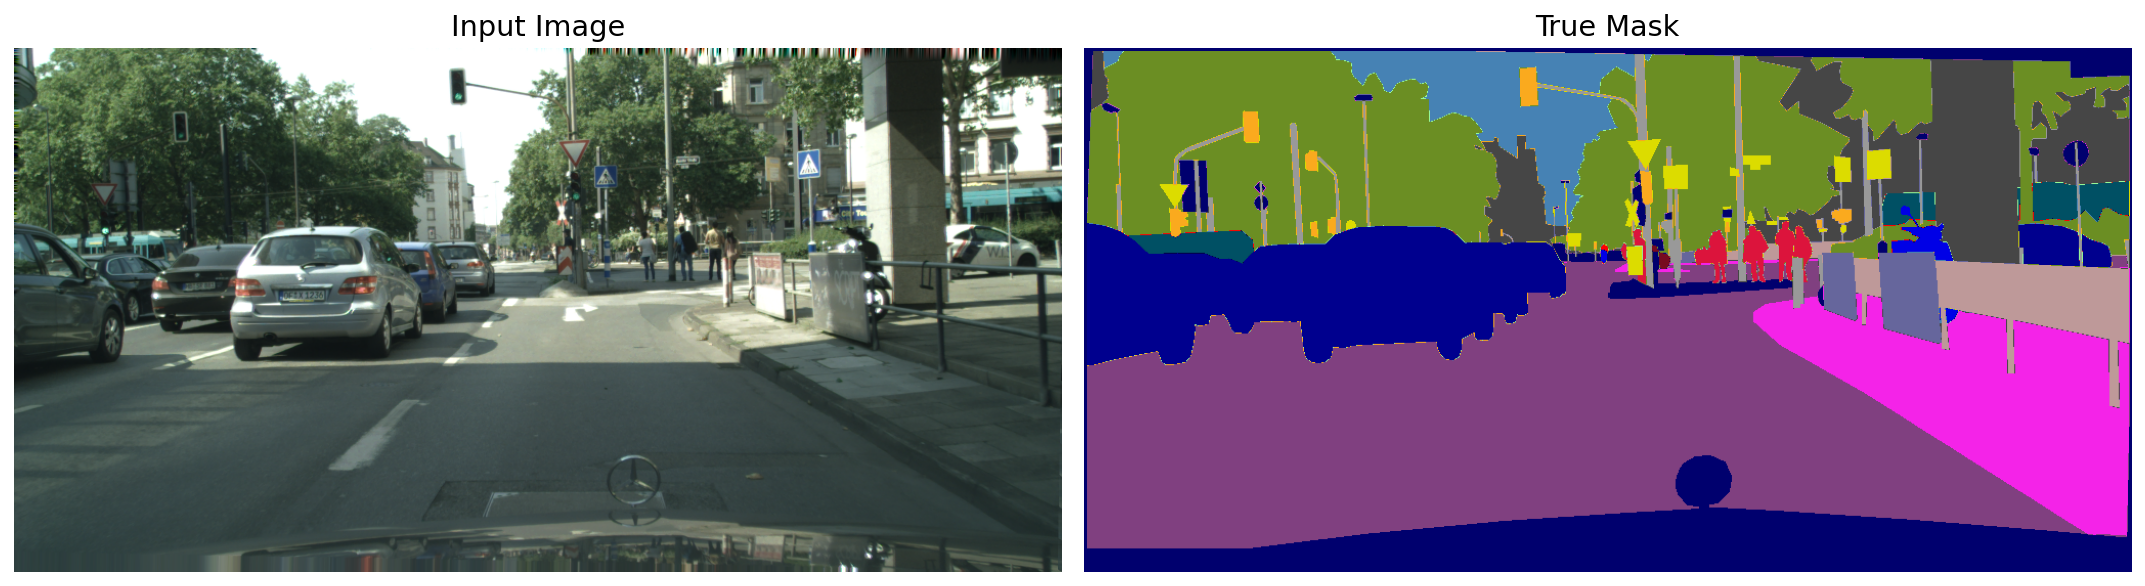

In [14]:
for image, mask in test.take(27): # 16
    sample_image, sample_mask = image, mask

sample_mask = tf.argmax(sample_mask, axis=-1)
sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

In [15]:
if fine:
    MODEL_PATH = "weights/HRNet_W40.h5"
else:
    MODEL_PATH = "weights/HRNet_W40_coarse.h5"

In [16]:
def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = label_to_rgb(pred_mask.numpy())
    return pred_mask


def show_predictions():
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if "u2net" in model.name:
        pred_mask = pred_mask[0]
    display([sample_image, sample_mask, create_mask(pred_mask)])

### Custom loop

In [17]:
with strategy.scope():
    
    initial_lr = 0.01 
    end_lr = 1e-5 
    decay_steps = 120000 
    learning_rate_fn = schedules.PolynomialDecay(
        initial_lr,
        decay_steps,
        end_lr,
        power=0.9
    )
    
    # model = U2NET(input_height=img_height, input_width=img_width, n_classes=n_classes)
    model = HRNet(input_height=img_height, input_width=img_width, n_classes=20, W=40)
    
    optimizer = SGD(learning_rate=learning_rate_fn, momentum=0.9, decay=0.0005)
    
    #  model.load_weights("weights/"+model.name+"_coarse.h5")

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [18]:
train_dataset = strategy.experimental_distribute_dataset(train_dataset)
test_dataset = strategy.experimental_distribute_dataset(test_dataset)

In [19]:
logger_file = "cityscapes_fine_hrnet.csv"

In [20]:
def iou_macro_coef(y_true, y_pred):
    smooth = 1
    iou_total = 0
    for i in range(1, n_classes):
        tp = tf.math.reduce_sum(y_pred[:,:,:,i] * y_true[:,:,:,i], axis=(1,2))
        fn = tf.math.reduce_sum(y_true[:,:,:,i] * (1 - y_pred[:,:,:,i]), axis=(1,2)) 
        fp = tf.math.reduce_sum(y_pred[:,:,:,i] * (1 - y_true[:,:,:,i]), axis=(1,2)) 
        iou = tf.math.reduce_mean(tf.math.divide_no_nan(tp+smooth, tp+fn+fp+smooth), axis=0)
        iou_total += iou

    iou_macro = iou_total / (n_classes - 1)
    return iou_macro


loss_object = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

def compute_loss(labels, predictions):
    per_example_loss = loss_object(labels, predictions)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=BATCH_SIZE)


def train_step(inputs):
    x, y = inputs
    with tf.GradientTape() as tape :
        output = model(x, training=True)
        loss = compute_loss(y, output)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss


@tf.function
def distributed_train_step(dist_inputs):
    per_replica_losses = strategy.run(train_step, args=(dist_inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)


def test_step(inputs):
    x, y = inputs
    output = model(x, training=False)
    loss = compute_loss(y, output)
    miou = iou_macro_coef(y, output)
    return loss, miou


@tf.function
def distributed_test_step(dist_inputs) :

    pe_loss, pe_miou = strategy.run(test_step, args=(dist_inputs,))
    loss = strategy.reduce(tf.distribute.ReduceOp.SUM, pe_loss, axis=None)
    miou = strategy.reduce(tf.distribute.ReduceOp.MEAN, pe_miou, axis=None)
    return loss, miou

In [21]:
def train(epochs):
    
    logfile = Path(logger_file)

    if not logfile.exists() :
        tmpf = logfile.open("w+")
        top_text = "epoch, loss, val_loss, miou\n"
        tmpf.write(top_text)
        tmpf.close()
    
    history = {"loss": [], "val_loss": [], "val_iou_coef": []}
    
    with strategy.scope():
    
        start_time = time()
        for epoch in range(epochs):
            epoch_start_time = time()
            
            train_losses = []
            valid_losses = []
            valid_mious = []

            for step, train_batch in enumerate(train_dataset):
                loss = distributed_train_step(train_batch)
                train_losses.append(loss.numpy())
                print("\r Batch {} -- loss: {:.4f}".format(step, loss.numpy()), end='')

            for val_batch in test_dataset:
                loss, miou = distributed_test_step(val_batch)
                valid_losses.append(loss.numpy())
                valid_mious.append(miou.numpy())

            train_loss = np.mean(train_losses)
            valid_loss = np.mean(valid_losses)
            valid_miou = np.mean(valid_mious)

            history['loss'].append(train_loss)
            history['val_loss'].append(valid_loss)
            history['val_iou_coef'].append(valid_miou)
            
            tmpf = logfile.open("a+")
            tmpf.write(",".join([str(epoch), str(train_loss), str(valid_loss), str(valid_miou)]) + "\n")
            tmpf.close()
            
            t_epoch = time() - epoch_start_time
            template = '\n Epoch {} -- Time: {:.2f}s, Loss: {:.4f}, Val Loss: {:.4f}, Val mIoU: {:.4f}'
            print(template.format(epoch+1, t_epoch, train_loss, valid_loss, valid_miou))
            
            model.save(MODEL_PATH)
            # show_predictions()
            
    end_time = time()
    t_minutes = (end_time - start_time) // 60
    print("Training finished in {:.2f} minutes".format(t_minutes))
    return model, history

In [22]:
model, history = train(epochs=300)

INFO:tensorflow:batch_all_reduce: 733 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 733 all-reduces with algorithm = nccl, num_packs = 1
 Batch 357 -- loss: 906400128.00000

KeyboardInterrupt: 

In [25]:
def plot_history(history, model):
        
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)  
    if "u2net" in model.name:
        plt.plot(history['d0_loss'], 'r', label='Training loss')
        plt.plot(history['val_d0_loss'], 'b', label='Validation loss')
    else: 
        plt.plot(history['loss'], 'r', label='Training loss')
        plt.plot(history['val_loss'], 'b', label='Validation loss')
    plt.title("Loss: "+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,2,2)
    if "u2net" in model.name:
        plt.plot(history['d0_iou_coef'], 'r', label='IoU coefficient')
        plt.plot(history['val_d0_iou_coef'], 'b', label='Validation IoU coefficient')
    else:
        plt.plot(history['iou_coef'], 'r', label='IoU coefficient')
        plt.plot(history['val_iou_coef'], 'b', label='Validation IoU coefficient')
    plt.title('IoU Coefficient: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})
    if fine:
        plt.savefig("plots/"+model.name+"_ga_learning_curves.png")
    else:
        plt.savefig("plots/"+model.name+"_ga_learning_curves_coarse.png")
    plt.show()

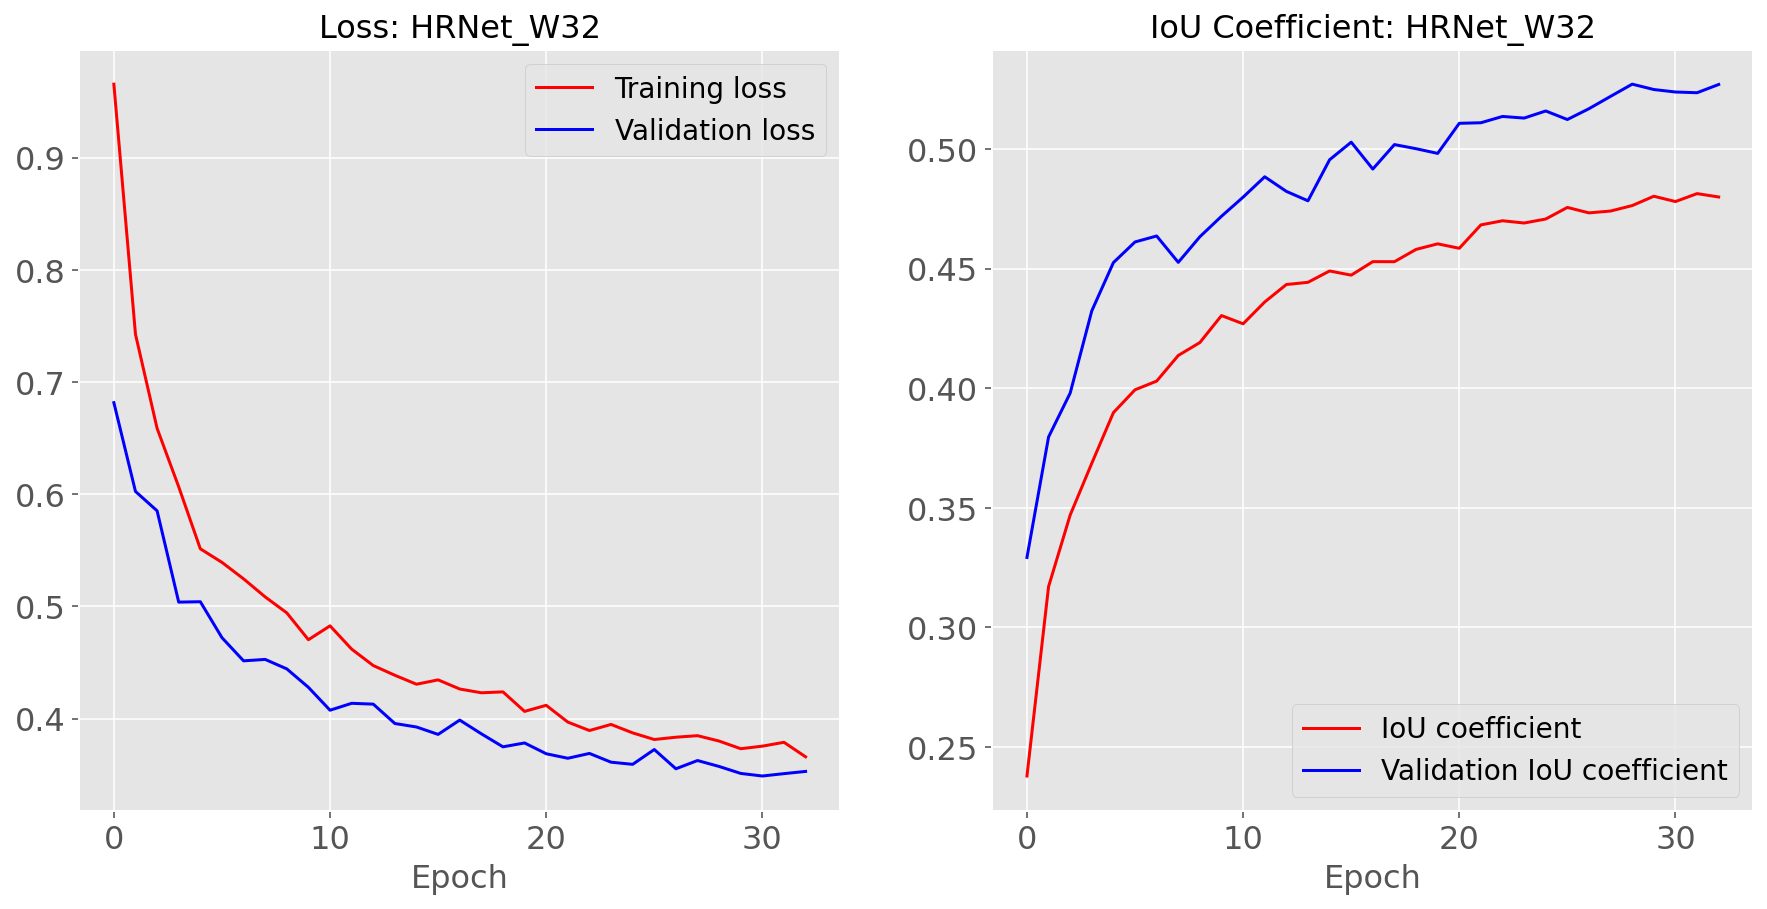

In [26]:
plot_history(history, model)

### Evaluation

In [27]:
def evaluate_iou(model, dataset, n_samples):
    
    iou_macro_scores = np.zeros((n_samples,))
    inf_times = np.zeros((n_samples, ))
    miou_op =  tf.keras.metrics.MeanIoU(num_classes=n_classes-1)
    
    for idx, (image, mask) in enumerate(dataset):
        print("\r Predicting {} \ {} ".format(idx+1, n_samples), end='')
        
        X = np.expand_dims(image.numpy(), axis=0)
        y_true = np.expand_dims(mask.numpy(), axis=0)
        
        t_start = time()
        y_pred = model.predict(X)
        t_end = time()
        t_inf = t_end-t_start
        
        inf_times[idx] = t_inf
        
        if "u2net" in model.name:
            y_pred = y_pred[0]
            
        y_pred = tf.image.resize(y_pred, (1024, 2048))
        threshold = tf.math.reduce_max(y_pred, axis=-1, keepdims=True)
        y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)
        
        y_pred = tf.cast(tf.squeeze(y_pred, axis=0), tf.int32)
        y_true = tf.cast(tf.squeeze(y_true, axis=0), tf.int32)
        
        y_true = tf.argmax(y_true[:,:,1:], axis=-1)
        y_pred = tf.argmax(y_pred[:,:,1:], axis=-1)
                
        # miou_op.reset_states()
        miou_op.update_state(y_true, y_pred)
        iou_macro = miou_op.result().numpy()
        iou_macro_scores[idx] = iou_macro
        
        if idx == (n_samples-1):
            break
    
    print("Average inference time: {:.2f}s".format(np.mean(inf_times)))
            
    return iou_macro_scores, miou_op


def mean_over_valid(x):
    return np.mean(x[x != -1])

To do: Make mean IoU a metric, so you can do

```python
loss, accuracy, miou = model.evaluate(dataset)
```

In [28]:
# iou_macro_scores, miou_op = evaluate_iou(model=model, dataset=test, n_samples=TEST_LENGTH)
iou_macro_scores, miou_op = evaluate_iou(model=model, dataset=eval, n_samples=TEST_LENGTH)
iou_mean_macro = np.mean(iou_macro_scores)

 Predicting 500 \ 500 Average inference time: 0.08s


In [29]:
union_int = np.sum(miou_op.get_weights()[0], axis=0)+np.sum(miou_op.get_weights()[0], axis=1)
inters = np.diag(miou_op.get_weights()[0])
ious = inters / (union_int-inters+1)

print("Mean IoU: {:.4f} \n".format(iou_mean_macro))
for i in range(ious.shape[0]) :
    print("IoU for {}: {:.2f}".format(catid2label[i+1].name, np.round(ious[i], 2)))

Mean IoU: 0.7020 

IoU for rail track: 0.92
IoU for tunnel: 0.79
IoU for traffic sign: 0.28
IoU for terrain: 0.85
IoU for sky: 0.87
IoU for rider: 0.49
IoU for license plate: 0.80


In [30]:
def plot_iou_catId(catId_label_map, n_classes, iou_class, model, iou_mean, current_dir):

    categories = [catId_label_map[i].category for i in range(1, n_classes)]
    cat_colors = {
        'void': colors.to_hex(list(np.array(catId_label_map[0].color)/255)),
        'flat': colors.to_hex(list(np.array(catId_label_map[1].color)/255)),
        'construction': colors.to_hex(list(np.array(catId_label_map[2].color)/255)),
        'object': colors.to_hex(list(np.array(catId_label_map[3].color)/255)),
        'nature': colors.to_hex(list(np.array(catId_label_map[4].color)/255)),
        'sky': colors.to_hex(list(np.array(catId_label_map[5].color)/255)),
        'human': colors.to_hex(list(np.array(catId_label_map[6].color)/255)),
        'vehicle': colors.to_hex(list(np.array(catId_label_map[7].color)/255))
    }
    _colors = [cat_colors[category] for category in categories]
    
    fig, ax = plt.subplots(figsize=(14,10))
    hbars = ax.barh(categories, iou_class, color=_colors)
    
    ax.set_xlabel("IoU Coefficient: ", fontsize=18)
    ax.set_ylabel("Category Name", fontsize=18)
    ax.set_title("Category Scores for {} - Mean IoU: {:.3f}".format(model.name, iou_mean), fontsize=22)
    ax.set_xlim([0, 1])
    
    ax.bar_label(hbars, fmt="%.2f", padding=3, fontsize=16)
    
    plt.savefig(current_dir+"plots/"+model.name+"_category_iou_scores.png")
    plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

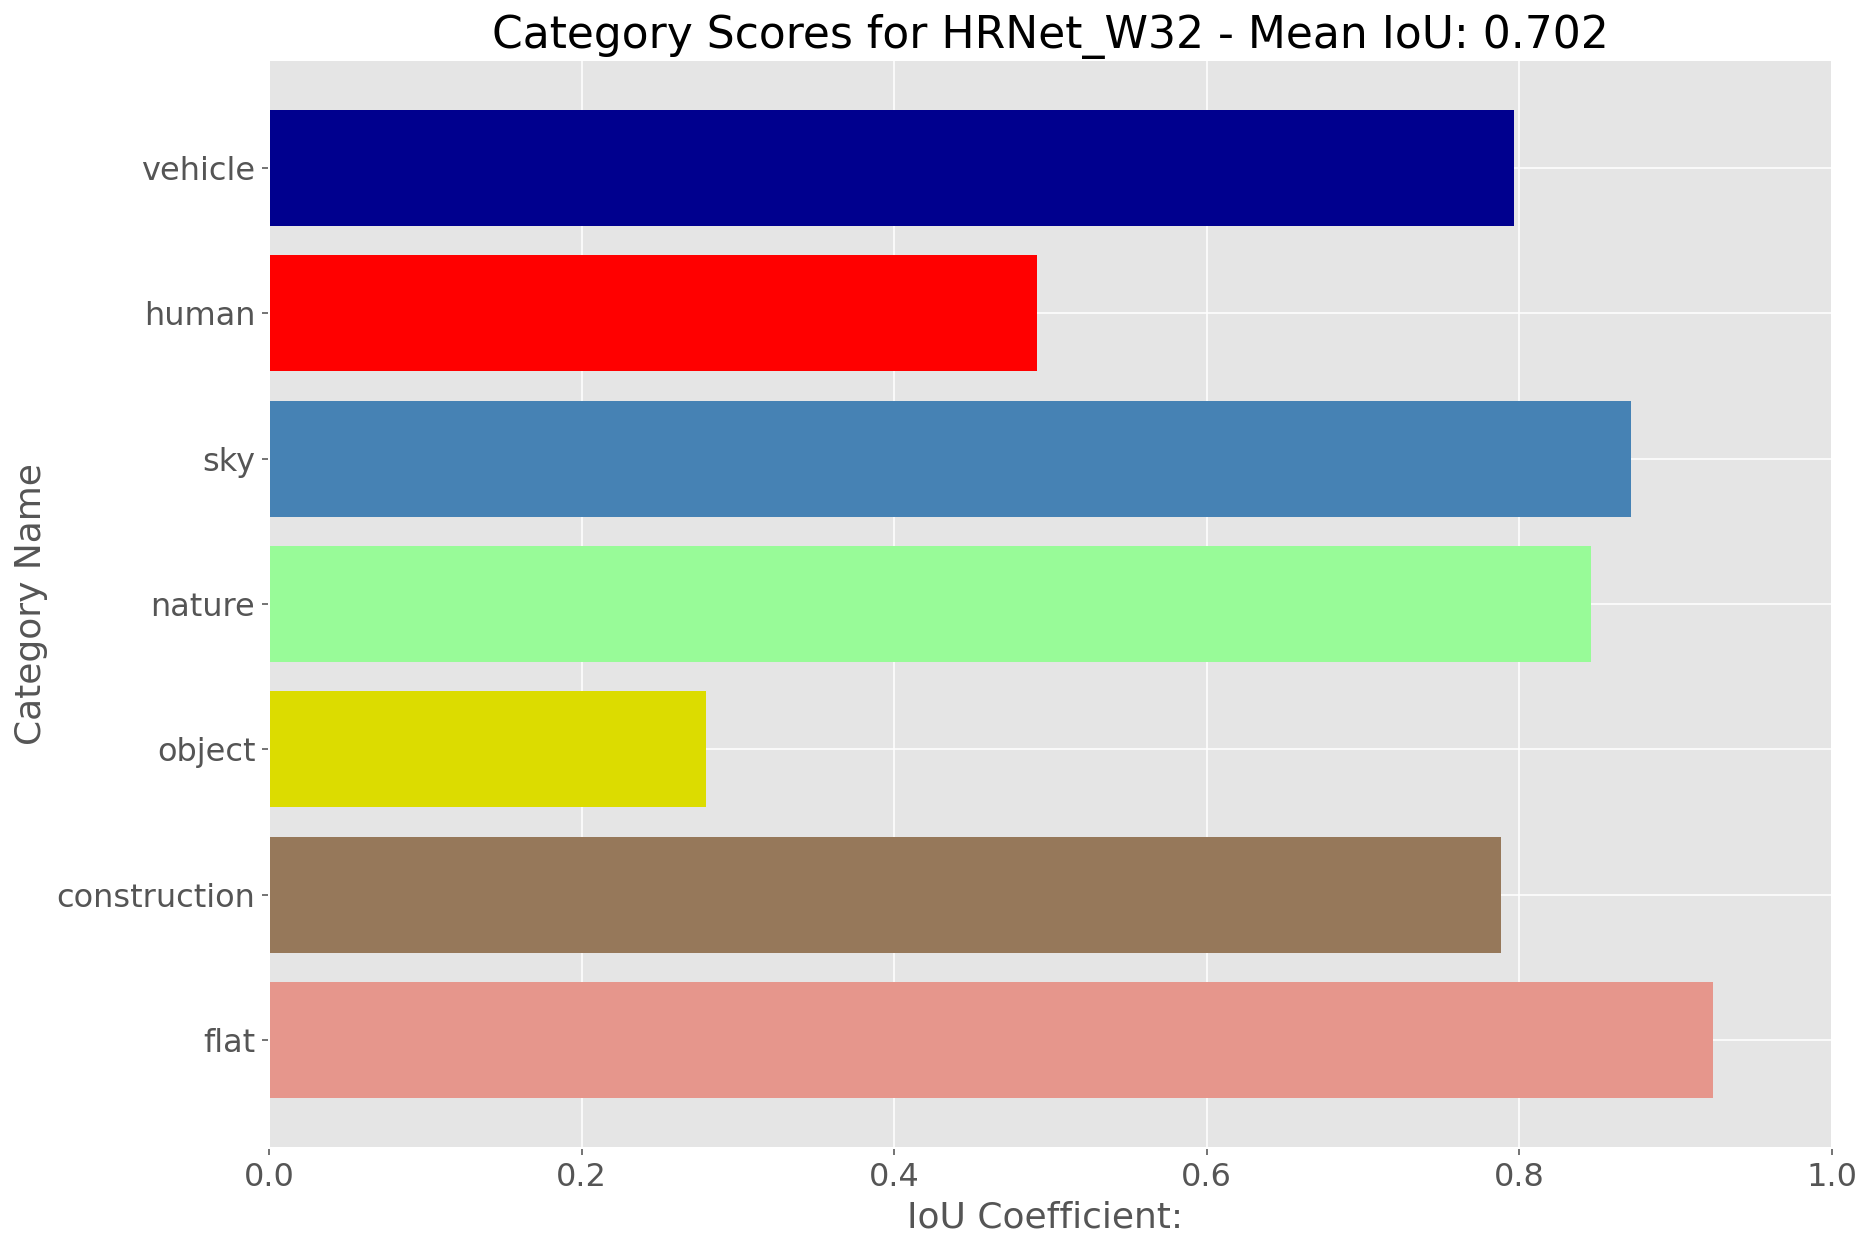

In [31]:
# plot_iou_trainId(
#     trainId_label_map=trainid2label,
#     catId_label_map=catId2label, 
#     n_classes=n_classes, 
#     iou_class=ious,
#     model=model, 
#     iou_mean=iou_mean_macro,
#     current_dir=""
# )

plot_iou_catId(
    catId_label_map=catid2label, 
    n_classes=n_classes, 
    iou_class=ious,
    model=model, 
    iou_mean=iou_mean_macro,
    current_dir=""
)

In [32]:
def visualize_confusion_matrix(confusion, metric, label_classes, model):
    plt.figure(figsize=(14,14))
    plt.title("{} Confusion Matrix, with Mean IoU = {:.3f}".format(model.name, metric), fontsize=22)
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.grid(False)
    fig.tight_layout()
    plt.show()

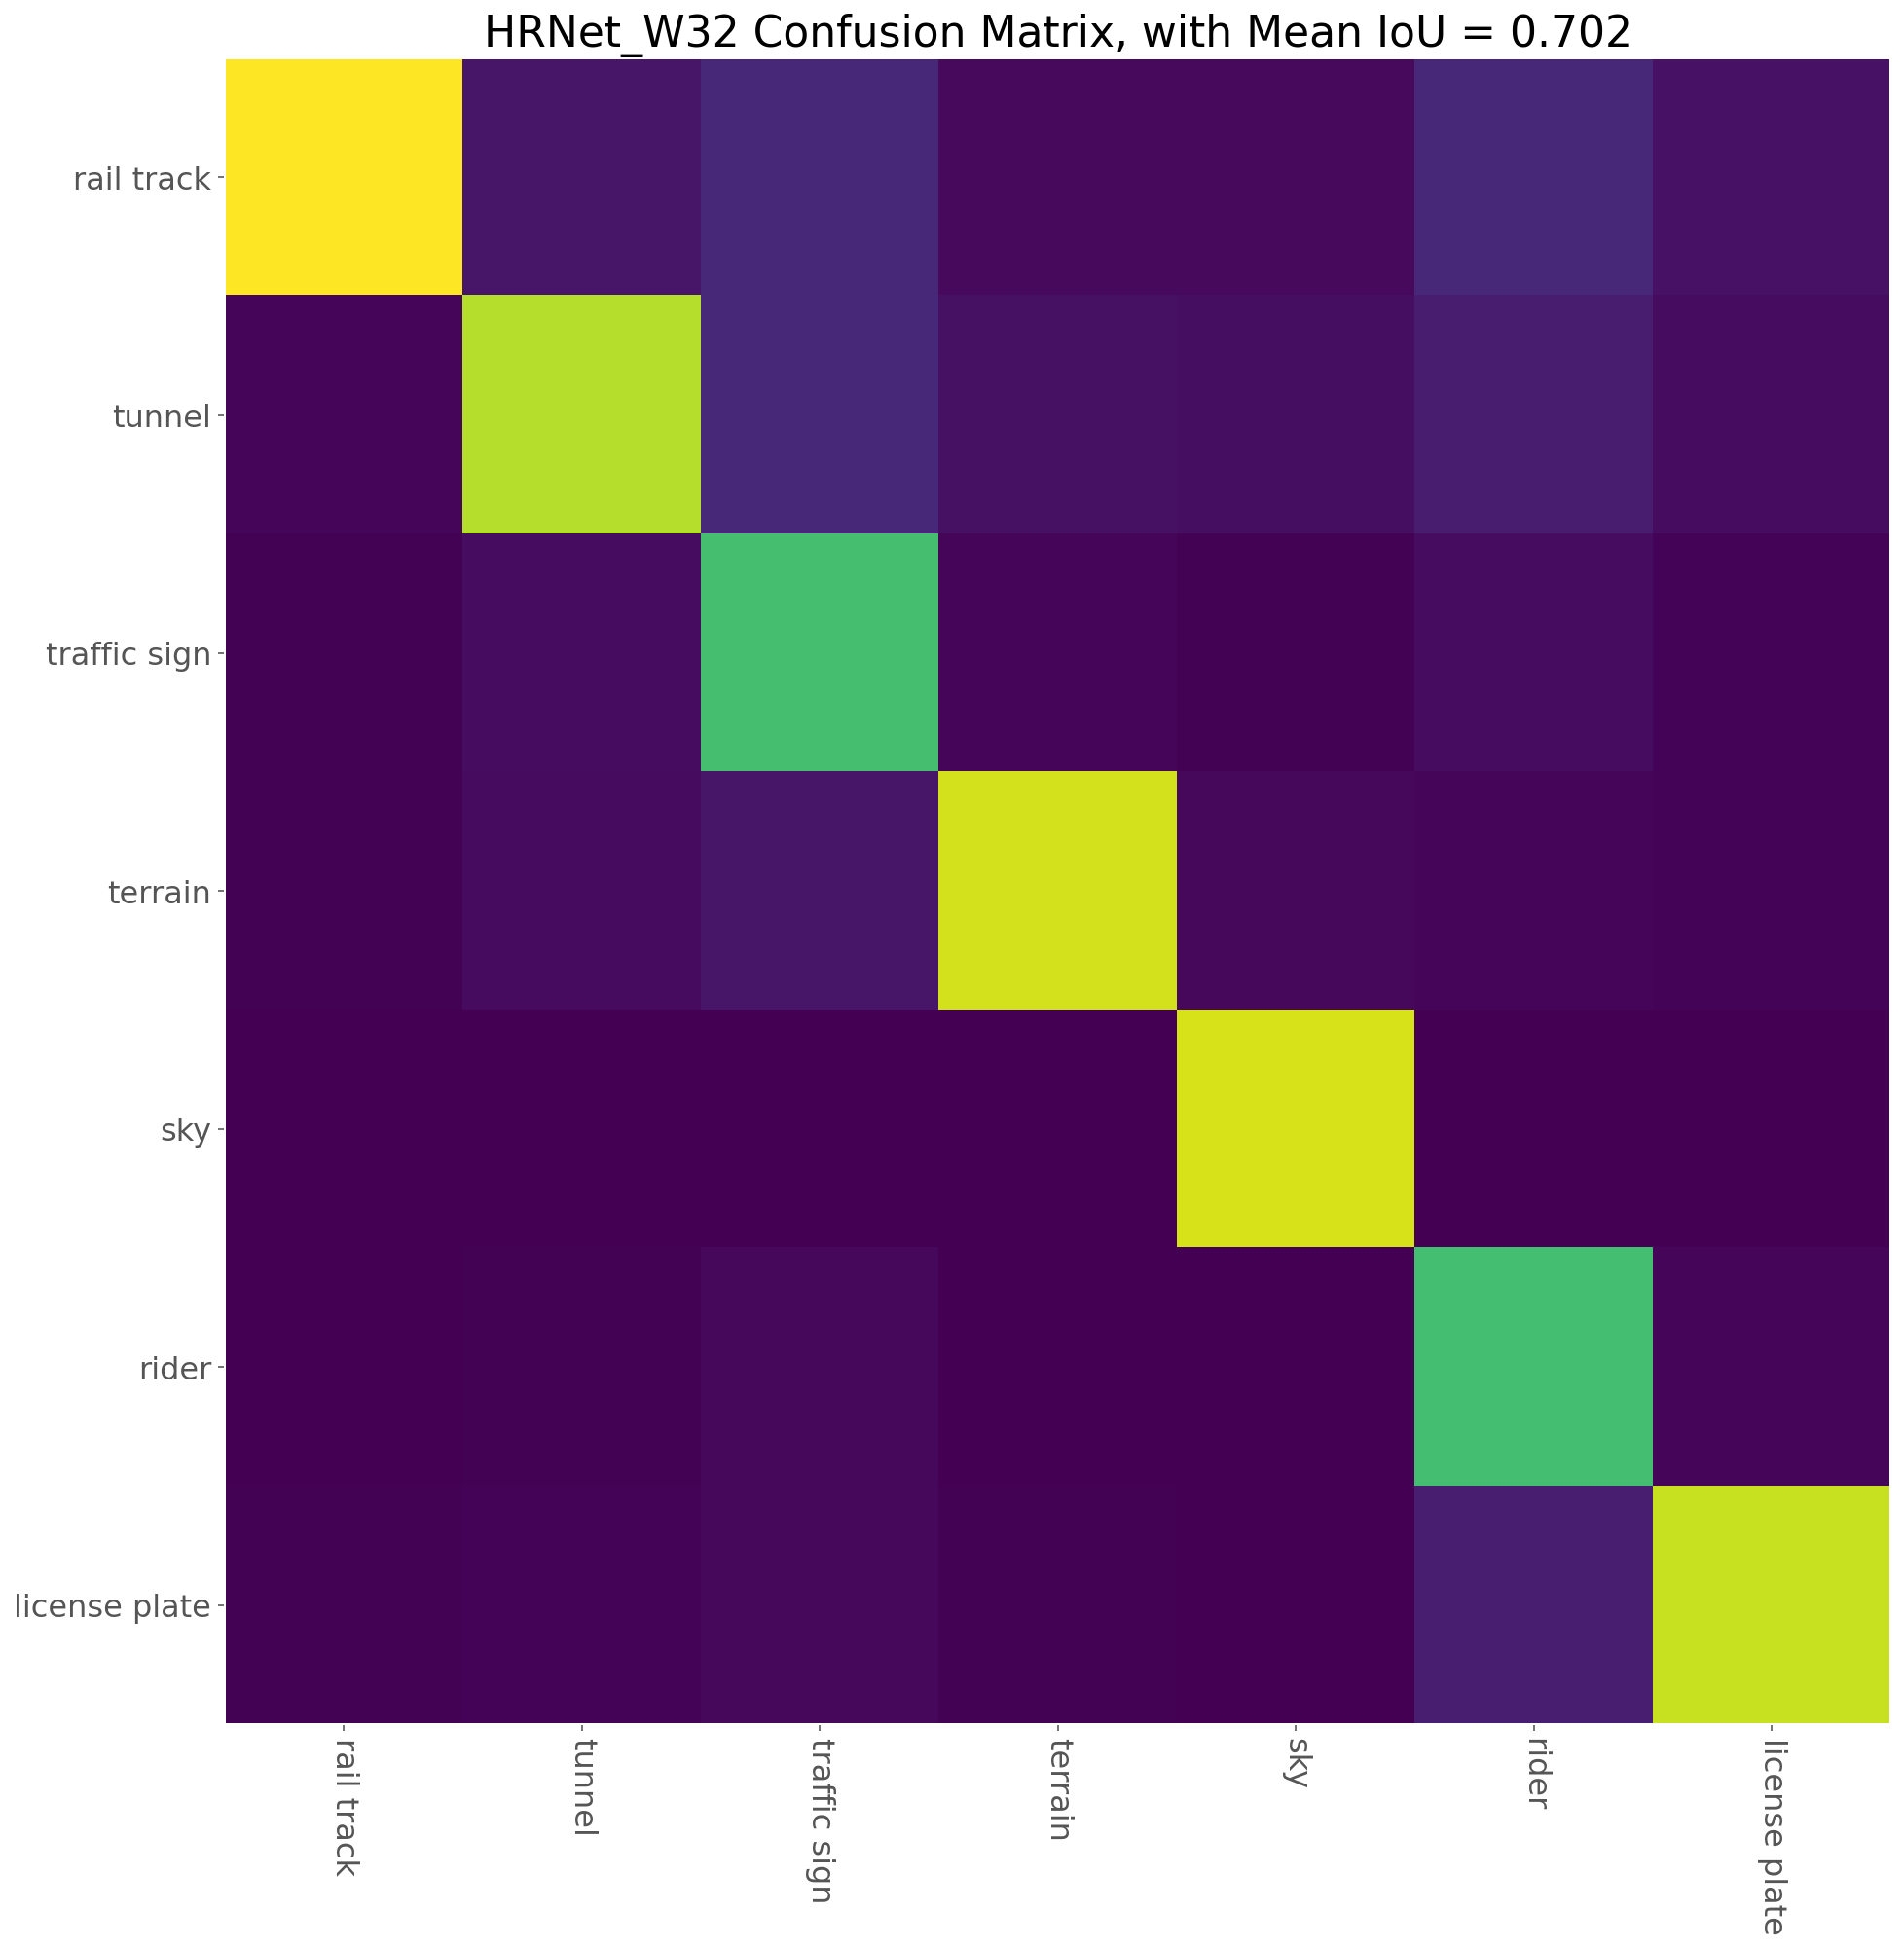

In [33]:
visualize_confusion_matrix(
    confusion = miou_op.get_weights()[0] / np.sum(miou_op.get_weights()[0], axis=0), 
    metric = iou_mean_macro, 
    label_classes = [catid2label[i].name for i in range(1, n_classes)],
    model = model
)